<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[22:10:01] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


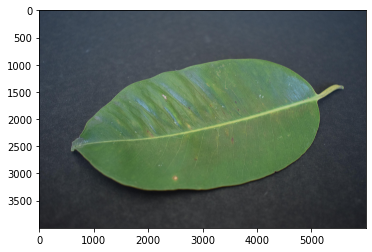

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

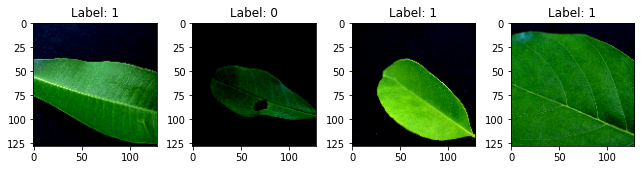

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[22:10:08] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[22:10:10] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2504587328962262 samples/sec                   batch loss = 0.949323296546936 | accuracy = 0.6


Epoch[1] Batch[10] Speed: 1.2664626704422273 samples/sec                   batch loss = 1.2971534729003906 | accuracy = 0.6


Epoch[1] Batch[15] Speed: 1.2687032253473614 samples/sec                   batch loss = 0.37726786732673645 | accuracy = 0.6333333333333333


Epoch[1] Batch[20] Speed: 1.2645368423044046 samples/sec                   batch loss = 0.735704243183136 | accuracy = 0.65


Epoch[1] Batch[25] Speed: 1.2653740362649404 samples/sec                   batch loss = 1.332977533340454 | accuracy = 0.62


Epoch[1] Batch[30] Speed: 1.2624867907896615 samples/sec                   batch loss = 0.6861217021942139 | accuracy = 0.6333333333333333


Epoch[1] Batch[35] Speed: 1.269663448542248 samples/sec                   batch loss = 1.488572120666504 | accuracy = 0.6571428571428571


Epoch[1] Batch[40] Speed: 1.2611651747293025 samples/sec                   batch loss = 0.43580180406570435 | accuracy = 0.64375


Epoch[1] Batch[45] Speed: 1.2786367074595073 samples/sec                   batch loss = 0.8887860774993896 | accuracy = 0.6333333333333333


Epoch[1] Batch[50] Speed: 1.267796855568762 samples/sec                   batch loss = 1.018548846244812 | accuracy = 0.635


Epoch[1] Batch[55] Speed: 1.2716496571092426 samples/sec                   batch loss = 0.36422571539878845 | accuracy = 0.6318181818181818


Epoch[1] Batch[60] Speed: 1.2689356348495446 samples/sec                   batch loss = 0.6693981289863586 | accuracy = 0.6166666666666667


Epoch[1] Batch[65] Speed: 1.2736107633868607 samples/sec                   batch loss = 0.17426301538944244 | accuracy = 0.6269230769230769


Epoch[1] Batch[70] Speed: 1.2680245245498314 samples/sec                   batch loss = 0.6532250046730042 | accuracy = 0.6321428571428571


Epoch[1] Batch[75] Speed: 1.2657687924297183 samples/sec                   batch loss = 0.30859386920928955 | accuracy = 0.64


Epoch[1] Batch[80] Speed: 1.2677753002435923 samples/sec                   batch loss = 0.18813461065292358 | accuracy = 0.64375


Epoch[1] Batch[85] Speed: 1.263290736253259 samples/sec                   batch loss = 0.5463885068893433 | accuracy = 0.6441176470588236


Epoch[1] Batch[90] Speed: 1.2708084728361653 samples/sec                   batch loss = 0.435488224029541 | accuracy = 0.6527777777777778


Epoch[1] Batch[95] Speed: 1.2692523362506267 samples/sec                   batch loss = 1.0338611602783203 | accuracy = 0.6473684210526316


Epoch[1] Batch[100] Speed: 1.2657662140210566 samples/sec                   batch loss = 0.35838207602500916 | accuracy = 0.65


Epoch[1] Batch[105] Speed: 1.2706243564882083 samples/sec                   batch loss = 0.46412980556488037 | accuracy = 0.65


Epoch[1] Batch[110] Speed: 1.2655492833335784 samples/sec                   batch loss = 0.46498173475265503 | accuracy = 0.6522727272727272


Epoch[1] Batch[115] Speed: 1.2709962051664645 samples/sec                   batch loss = 0.7265291810035706 | accuracy = 0.6478260869565218


Epoch[1] Batch[120] Speed: 1.2718589460862166 samples/sec                   batch loss = 0.6174109578132629 | accuracy = 0.65


Epoch[1] Batch[125] Speed: 1.2684095247506024 samples/sec                   batch loss = 0.5200253129005432 | accuracy = 0.652


Epoch[1] Batch[130] Speed: 1.2670038150846201 samples/sec                   batch loss = 0.6197808980941772 | accuracy = 0.6519230769230769


Epoch[1] Batch[135] Speed: 1.267599915046135 samples/sec                   batch loss = 0.27489787340164185 | accuracy = 0.65


Epoch[1] Batch[140] Speed: 1.2650248323054998 samples/sec                   batch loss = 0.680192232131958 | accuracy = 0.6517857142857143


Epoch[1] Batch[145] Speed: 1.2657224781707743 samples/sec                   batch loss = 0.32866811752319336 | accuracy = 0.656896551724138


Epoch[1] Batch[150] Speed: 1.267122186331253 samples/sec                   batch loss = 1.5715280771255493 | accuracy = 0.66


Epoch[1] Batch[155] Speed: 1.2672002832715477 samples/sec                   batch loss = 0.6618118286132812 | accuracy = 0.6629032258064517


Epoch[1] Batch[160] Speed: 1.2701331915514404 samples/sec                   batch loss = 1.7757469415664673 | accuracy = 0.659375


Epoch[1] Batch[165] Speed: 1.2688255607770735 samples/sec                   batch loss = 0.49826252460479736 | accuracy = 0.6621212121212121


Epoch[1] Batch[170] Speed: 1.2667879904275945 samples/sec                   batch loss = 0.15246103703975677 | accuracy = 0.6691176470588235


Epoch[1] Batch[175] Speed: 1.27552429858851 samples/sec                   batch loss = 0.5177559852600098 | accuracy = 0.6685714285714286


Epoch[1] Batch[180] Speed: 1.2668789607391888 samples/sec                   batch loss = 1.1117817163467407 | accuracy = 0.6652777777777777


Epoch[1] Batch[185] Speed: 1.2691311665765217 samples/sec                   batch loss = 0.767546534538269 | accuracy = 0.6662162162162162


Epoch[1] Batch[190] Speed: 1.2679145126617888 samples/sec                   batch loss = 1.273546576499939 | accuracy = 0.6657894736842105


Epoch[1] Batch[195] Speed: 1.2677833474792466 samples/sec                   batch loss = 0.22921015322208405 | accuracy = 0.6666666666666666


Epoch[1] Batch[200] Speed: 1.2692260264469497 samples/sec                   batch loss = 0.8692200779914856 | accuracy = 0.66375


Epoch[1] Batch[205] Speed: 1.2653055160260038 samples/sec                   batch loss = 0.4805004298686981 | accuracy = 0.6634146341463415


Epoch[1] Batch[210] Speed: 1.2669531049881833 samples/sec                   batch loss = 0.2309722751379013 | accuracy = 0.6654761904761904


Epoch[1] Batch[215] Speed: 1.267725103127433 samples/sec                   batch loss = 0.762530505657196 | accuracy = 0.6662790697674419


Epoch[1] Batch[220] Speed: 1.2663657378997093 samples/sec                   batch loss = 0.439902126789093 | accuracy = 0.6659090909090909


Epoch[1] Batch[225] Speed: 1.2671144345866354 samples/sec                   batch loss = 0.37030884623527527 | accuracy = 0.6666666666666666


Epoch[1] Batch[230] Speed: 1.2655611209421682 samples/sec                   batch loss = 0.18629907071590424 | accuracy = 0.6663043478260869


Epoch[1] Batch[235] Speed: 1.2688426416393446 samples/sec                   batch loss = 0.390493243932724 | accuracy = 0.6606382978723404


Epoch[1] Batch[240] Speed: 1.2698935186383635 samples/sec                   batch loss = 1.1099145412445068 | accuracy = 0.6583333333333333


Epoch[1] Batch[245] Speed: 1.265257231847088 samples/sec                   batch loss = 0.4995388984680176 | accuracy = 0.6591836734693878


Epoch[1] Batch[250] Speed: 1.2658591388616847 samples/sec                   batch loss = 0.48618078231811523 | accuracy = 0.658


Epoch[1] Batch[255] Speed: 1.2662519996968944 samples/sec                   batch loss = 0.3169959783554077 | accuracy = 0.6588235294117647


Epoch[1] Batch[260] Speed: 1.2681657088839393 samples/sec                   batch loss = 1.1895307302474976 | accuracy = 0.6586538461538461


Epoch[1] Batch[265] Speed: 1.2670931895505317 samples/sec                   batch loss = 0.24094291031360626 | accuracy = 0.660377358490566


Epoch[1] Batch[270] Speed: 1.26948561940332 samples/sec                   batch loss = 0.4325573742389679 | accuracy = 0.6592592592592592


Epoch[1] Batch[275] Speed: 1.2723000183899853 samples/sec                   batch loss = 0.405636727809906 | accuracy = 0.66


Epoch[1] Batch[280] Speed: 1.2657266797369477 samples/sec                   batch loss = 0.28554674983024597 | accuracy = 0.6607142857142857


Epoch[1] Batch[285] Speed: 1.2701460766527868 samples/sec                   batch loss = 0.2740606367588043 | accuracy = 0.6596491228070176


Epoch[1] Batch[290] Speed: 1.2686876832406602 samples/sec                   batch loss = 0.7381947636604309 | accuracy = 0.6603448275862069


Epoch[1] Batch[295] Speed: 1.2677730010521693 samples/sec                   batch loss = 0.2477709800004959 | accuracy = 0.6627118644067796


Epoch[1] Batch[300] Speed: 1.265617734503266 samples/sec                   batch loss = 0.5683477520942688 | accuracy = 0.6633333333333333


Epoch[1] Batch[305] Speed: 1.263082735935841 samples/sec                   batch loss = 1.0101217031478882 | accuracy = 0.6622950819672131


Epoch[1] Batch[310] Speed: 1.2739363808447448 samples/sec                   batch loss = 0.5542008280754089 | accuracy = 0.6653225806451613


Epoch[1] Batch[315] Speed: 1.2666204326339794 samples/sec                   batch loss = 0.6613686680793762 | accuracy = 0.6666666666666666


Epoch[1] Batch[320] Speed: 1.273366200437115 samples/sec                   batch loss = 0.2992062568664551 | accuracy = 0.66875


Epoch[1] Batch[325] Speed: 1.2644732730556327 samples/sec                   batch loss = 0.6224727630615234 | accuracy = 0.6723076923076923


Epoch[1] Batch[330] Speed: 1.2701928113781524 samples/sec                   batch loss = 1.3366676568984985 | accuracy = 0.6734848484848485


Epoch[1] Batch[335] Speed: 1.2698432497577776 samples/sec                   batch loss = 0.14312134683132172 | accuracy = 0.676865671641791


Epoch[1] Batch[340] Speed: 1.2680555766555313 samples/sec                   batch loss = 0.39236536622047424 | accuracy = 0.6772058823529412


Epoch[1] Batch[345] Speed: 1.2687785428012321 samples/sec                   batch loss = 1.0408728122711182 | accuracy = 0.677536231884058


Epoch[1] Batch[350] Speed: 1.2716873452479436 samples/sec                   batch loss = 0.5733277797698975 | accuracy = 0.6771428571428572


Epoch[1] Batch[355] Speed: 1.271309023002842 samples/sec                   batch loss = 0.6837425231933594 | accuracy = 0.6774647887323944


Epoch[1] Batch[360] Speed: 1.2673472196601647 samples/sec                   batch loss = 0.24927563965320587 | accuracy = 0.6777777777777778


Epoch[1] Batch[365] Speed: 1.2709966866027067 samples/sec                   batch loss = 0.6131132245063782 | accuracy = 0.6794520547945205


Epoch[1] Batch[370] Speed: 1.2697403215049783 samples/sec                   batch loss = 0.6091500520706177 | accuracy = 0.6797297297297298


Epoch[1] Batch[375] Speed: 1.2742590678045658 samples/sec                   batch loss = 0.9214735627174377 | accuracy = 0.6786666666666666


Epoch[1] Batch[380] Speed: 1.2707826760095045 samples/sec                   batch loss = 0.9189466834068298 | accuracy = 0.680921052631579


Epoch[1] Batch[385] Speed: 1.2722653812682359 samples/sec                   batch loss = 0.633295476436615 | accuracy = 0.6805194805194805


Epoch[1] Batch[390] Speed: 1.26058770717023 samples/sec                   batch loss = 0.4366154372692108 | accuracy = 0.6814102564102564


Epoch[1] Batch[395] Speed: 1.2720484356325772 samples/sec                   batch loss = 0.4667285978794098 | accuracy = 0.6810126582278481


Epoch[1] Batch[400] Speed: 1.2697919277027916 samples/sec                   batch loss = 0.3791079819202423 | accuracy = 0.680625


Epoch[1] Batch[405] Speed: 1.2753921360319675 samples/sec                   batch loss = 0.9007733464241028 | accuracy = 0.6802469135802469


Epoch[1] Batch[410] Speed: 1.268426882108206 samples/sec                   batch loss = 0.31771811842918396 | accuracy = 0.6810975609756098


Epoch[1] Batch[415] Speed: 1.2698514193814812 samples/sec                   batch loss = 0.3379206657409668 | accuracy = 0.6819277108433734


Epoch[1] Batch[420] Speed: 1.2747834560053783 samples/sec                   batch loss = 0.6414750218391418 | accuracy = 0.6785714285714286


Epoch[1] Batch[425] Speed: 1.2770767110776928 samples/sec                   batch loss = 0.5382075309753418 | accuracy = 0.6805882352941176


Epoch[1] Batch[430] Speed: 1.275410654593411 samples/sec                   batch loss = 1.2310428619384766 | accuracy = 0.6808139534883721


Epoch[1] Batch[435] Speed: 1.2714916996768753 samples/sec                   batch loss = 0.9665083885192871 | accuracy = 0.6804597701149425


Epoch[1] Batch[440] Speed: 1.264645029557503 samples/sec                   batch loss = 0.5029715895652771 | accuracy = 0.6823863636363636


Epoch[1] Batch[445] Speed: 1.2649699885455226 samples/sec                   batch loss = 0.5580843091011047 | accuracy = 0.6831460674157304


Epoch[1] Batch[450] Speed: 1.2725735152621522 samples/sec                   batch loss = 2.033400058746338 | accuracy = 0.6833333333333333


Epoch[1] Batch[455] Speed: 1.2727076044836478 samples/sec                   batch loss = 0.31431013345718384 | accuracy = 0.6846153846153846


Epoch[1] Batch[460] Speed: 1.2678383396572037 samples/sec                   batch loss = 0.7608739137649536 | accuracy = 0.6847826086956522


Epoch[1] Batch[465] Speed: 1.274008451160702 samples/sec                   batch loss = 0.15541276335716248 | accuracy = 0.6844086021505377


Epoch[1] Batch[470] Speed: 1.2685613457994578 samples/sec                   batch loss = 0.7384244203567505 | accuracy = 0.6851063829787234


Epoch[1] Batch[475] Speed: 1.2733360474008553 samples/sec                   batch loss = 0.5048509836196899 | accuracy = 0.6868421052631579


Epoch[1] Batch[480] Speed: 1.265274216770501 samples/sec                   batch loss = 0.5401713252067566 | accuracy = 0.6854166666666667


Epoch[1] Batch[485] Speed: 1.2696444239209221 samples/sec                   batch loss = 0.47464603185653687 | accuracy = 0.6871134020618557


Epoch[1] Batch[490] Speed: 1.270012430473638 samples/sec                   batch loss = 0.46109259128570557 | accuracy = 0.6877551020408164


Epoch[1] Batch[495] Speed: 1.267179801034864 samples/sec                   batch loss = 0.19843758642673492 | accuracy = 0.6883838383838384


Epoch[1] Batch[500] Speed: 1.2721542464700581 samples/sec                   batch loss = 0.19574108719825745 | accuracy = 0.69


Epoch[1] Batch[505] Speed: 1.2688384193609379 samples/sec                   batch loss = 0.6637717485427856 | accuracy = 0.691089108910891


Epoch[1] Batch[510] Speed: 1.2661713439763713 samples/sec                   batch loss = 0.33533769845962524 | accuracy = 0.692156862745098


Epoch[1] Batch[515] Speed: 1.2674420045284953 samples/sec                   batch loss = 1.396384596824646 | accuracy = 0.6912621359223301


Epoch[1] Batch[520] Speed: 1.2750812790199428 samples/sec                   batch loss = 0.51692134141922 | accuracy = 0.6918269230769231


Epoch[1] Batch[525] Speed: 1.2690535034147212 samples/sec                   batch loss = 0.33958181738853455 | accuracy = 0.690952380952381


Epoch[1] Batch[530] Speed: 1.2771315402668826 samples/sec                   batch loss = 0.7244006395339966 | accuracy = 0.6900943396226416


Epoch[1] Batch[535] Speed: 1.27776611248264 samples/sec                   batch loss = 0.7207230925559998 | accuracy = 0.6906542056074766


Epoch[1] Batch[540] Speed: 1.2724204428924777 samples/sec                   batch loss = 0.6681563854217529 | accuracy = 0.6893518518518519


Epoch[1] Batch[545] Speed: 1.2674603886898994 samples/sec                   batch loss = 1.411347508430481 | accuracy = 0.6876146788990826


Epoch[1] Batch[550] Speed: 1.27685812163247 samples/sec                   batch loss = 0.7683620452880859 | accuracy = 0.6868181818181818


Epoch[1] Batch[555] Speed: 1.270566235695522 samples/sec                   batch loss = 0.2497314065694809 | accuracy = 0.6878378378378378


Epoch[1] Batch[560] Speed: 1.2735251073339284 samples/sec                   batch loss = 0.45293596386909485 | accuracy = 0.6888392857142858


Epoch[1] Batch[565] Speed: 1.2696824737337205 samples/sec                   batch loss = 0.214330792427063 | accuracy = 0.6867256637168142


Epoch[1] Batch[570] Speed: 1.2647343575662624 samples/sec                   batch loss = 0.30343422293663025 | accuracy = 0.6850877192982456


Epoch[1] Batch[575] Speed: 1.2671409440316406 samples/sec                   batch loss = 0.7124089598655701 | accuracy = 0.6847826086956522


Epoch[1] Batch[580] Speed: 1.2728321619007705 samples/sec                   batch loss = 0.8025059700012207 | accuracy = 0.6844827586206896


Epoch[1] Batch[585] Speed: 1.2669450682889476 samples/sec                   batch loss = 0.6697882413864136 | accuracy = 0.6841880341880342


Epoch[1] Batch[590] Speed: 1.27111060467022 samples/sec                   batch loss = 0.6292285919189453 | accuracy = 0.6838983050847458


Epoch[1] Batch[595] Speed: 1.2679519797239125 samples/sec                   batch loss = 0.6528102159500122 | accuracy = 0.6836134453781513


Epoch[1] Batch[600] Speed: 1.2764432117140632 samples/sec                   batch loss = 0.3525022566318512 | accuracy = 0.6845833333333333


Epoch[1] Batch[605] Speed: 1.2700332928086624 samples/sec                   batch loss = 0.6145761013031006 | accuracy = 0.684297520661157


Epoch[1] Batch[610] Speed: 1.2766868208152746 samples/sec                   batch loss = 0.2722235918045044 | accuracy = 0.684016393442623


Epoch[1] Batch[615] Speed: 1.2750853491334364 samples/sec                   batch loss = 0.6451399922370911 | accuracy = 0.6849593495934959


Epoch[1] Batch[620] Speed: 1.270364297657432 samples/sec                   batch loss = 0.21726380288600922 | accuracy = 0.6866935483870967


Epoch[1] Batch[625] Speed: 1.2751672414612132 samples/sec                   batch loss = 1.0720993280410767 | accuracy = 0.6872


Epoch[1] Batch[630] Speed: 1.2812776412025846 samples/sec                   batch loss = 0.6758838891983032 | accuracy = 0.6873015873015873


Epoch[1] Batch[635] Speed: 1.277745579203441 samples/sec                   batch loss = 0.5569010376930237 | accuracy = 0.6866141732283465


Epoch[1] Batch[640] Speed: 1.2748291764574293 samples/sec                   batch loss = 0.9853447079658508 | accuracy = 0.68671875


Epoch[1] Batch[645] Speed: 1.2781009661624136 samples/sec                   batch loss = 0.41612040996551514 | accuracy = 0.686046511627907


Epoch[1] Batch[650] Speed: 1.2744027088058065 samples/sec                   batch loss = 0.23472879827022552 | accuracy = 0.686923076923077


Epoch[1] Batch[655] Speed: 1.2805208172971352 samples/sec                   batch loss = 0.4682832956314087 | accuracy = 0.6870229007633588


Epoch[1] Batch[660] Speed: 1.2779133680798611 samples/sec                   batch loss = 0.8440026044845581 | accuracy = 0.6867424242424243


Epoch[1] Batch[665] Speed: 1.2711671379529312 samples/sec                   batch loss = 0.4274848699569702 | accuracy = 0.687218045112782


Epoch[1] Batch[670] Speed: 1.2804682376299255 samples/sec                   batch loss = 0.9753239154815674 | accuracy = 0.6865671641791045


Epoch[1] Batch[675] Speed: 1.2754667952988437 samples/sec                   batch loss = 0.46010422706604004 | accuracy = 0.687037037037037


Epoch[1] Batch[680] Speed: 1.2767920444025982 samples/sec                   batch loss = 0.3907071352005005 | accuracy = 0.6878676470588235


Epoch[1] Batch[685] Speed: 1.2674154824853474 samples/sec                   batch loss = 0.6702762842178345 | accuracy = 0.6875912408759124


Epoch[1] Batch[690] Speed: 1.2723000183899853 samples/sec                   batch loss = 0.7604983448982239 | accuracy = 0.688768115942029


Epoch[1] Batch[695] Speed: 1.2780620206710178 samples/sec                   batch loss = 0.491077184677124 | accuracy = 0.6899280575539568


Epoch[1] Batch[700] Speed: 1.2770544502152323 samples/sec                   batch loss = 0.6395629048347473 | accuracy = 0.6896428571428571


Epoch[1] Batch[705] Speed: 1.2699339865369201 samples/sec                   batch loss = 0.19754958152770996 | accuracy = 0.6904255319148936


Epoch[1] Batch[710] Speed: 1.2762217324747505 samples/sec                   batch loss = 1.0760140419006348 | accuracy = 0.6915492957746479


Epoch[1] Batch[715] Speed: 1.2708706590444194 samples/sec                   batch loss = 0.1731194704771042 | accuracy = 0.693006993006993


Epoch[1] Batch[720] Speed: 1.2695819733637155 samples/sec                   batch loss = 0.8871026039123535 | accuracy = 0.6923611111111111


Epoch[1] Batch[725] Speed: 1.266413533156932 samples/sec                   batch loss = 0.6082444190979004 | accuracy = 0.6917241379310345


Epoch[1] Batch[730] Speed: 1.2658341156198614 samples/sec                   batch loss = 0.3475131690502167 | accuracy = 0.6924657534246575


Epoch[1] Batch[735] Speed: 1.2728441361462142 samples/sec                   batch loss = 0.7520747184753418 | accuracy = 0.6925170068027211


Epoch[1] Batch[740] Speed: 1.2716451269718696 samples/sec                   batch loss = 0.23302459716796875 | accuracy = 0.6935810810810811


Epoch[1] Batch[745] Speed: 1.2720923203978443 samples/sec                   batch loss = 1.4551358222961426 | accuracy = 0.6939597315436241


Epoch[1] Batch[750] Speed: 1.2732547766171292 samples/sec                   batch loss = 0.23955513536930084 | accuracy = 0.694


Epoch[1] Batch[755] Speed: 1.2722462785929443 samples/sec                   batch loss = 0.49837756156921387 | accuracy = 0.6940397350993377


Epoch[1] Batch[760] Speed: 1.26905033565068 samples/sec                   batch loss = 0.7716203331947327 | accuracy = 0.6930921052631579


Epoch[1] Batch[765] Speed: 1.268515690165875 samples/sec                   batch loss = 0.635267972946167 | accuracy = 0.6928104575163399


Epoch[1] Batch[770] Speed: 1.2679754576560072 samples/sec                   batch loss = 1.348339319229126 | accuracy = 0.6925324675324676


Epoch[1] Batch[775] Speed: 1.2681324467430157 samples/sec                   batch loss = 0.24210955202579498 | accuracy = 0.6935483870967742


Epoch[1] Batch[780] Speed: 1.273115838238893 samples/sec                   batch loss = 1.098428726196289 | accuracy = 0.6942307692307692


Epoch[1] Batch[785] Speed: 1.2704479897693035 samples/sec                   batch loss = 0.940510630607605 | accuracy = 0.6939490445859873


[Epoch 1] training: accuracy=0.6938451776649747
[Epoch 1] time cost: 648.0310220718384
[Epoch 1] validation: validation accuracy=0.7555555555555555


Epoch[2] Batch[5] Speed: 1.2674807842429772 samples/sec                   batch loss = 0.3323492407798767 | accuracy = 0.8


Epoch[2] Batch[10] Speed: 1.274529244246631 samples/sec                   batch loss = 0.331387460231781 | accuracy = 0.725


Epoch[2] Batch[15] Speed: 1.2722561192934243 samples/sec                   batch loss = 0.33478108048439026 | accuracy = 0.7166666666666667


Epoch[2] Batch[20] Speed: 1.2702836943011584 samples/sec                   batch loss = 0.681460976600647 | accuracy = 0.725


Epoch[2] Batch[25] Speed: 1.269145759479815 samples/sec                   batch loss = 0.6138812303543091 | accuracy = 0.71


Epoch[2] Batch[30] Speed: 1.271440244290415 samples/sec                   batch loss = 0.7003937363624573 | accuracy = 0.7083333333333334


Epoch[2] Batch[35] Speed: 1.2676578605487012 samples/sec                   batch loss = 0.14504218101501465 | accuracy = 0.7357142857142858


Epoch[2] Batch[40] Speed: 1.2696345274999057 samples/sec                   batch loss = 0.5034712553024292 | accuracy = 0.75


Epoch[2] Batch[45] Speed: 1.2679763201272116 samples/sec                   batch loss = 0.38758301734924316 | accuracy = 0.7666666666666667


Epoch[2] Batch[50] Speed: 1.2665809405916488 samples/sec                   batch loss = 0.236032634973526 | accuracy = 0.77


Epoch[2] Batch[55] Speed: 1.267255799204971 samples/sec                   batch loss = 0.27072107791900635 | accuracy = 0.7636363636363637


Epoch[2] Batch[60] Speed: 1.2671794181956222 samples/sec                   batch loss = 0.4807673990726471 | accuracy = 0.7583333333333333


Epoch[2] Batch[65] Speed: 1.2729905491703246 samples/sec                   batch loss = 1.057639718055725 | accuracy = 0.7538461538461538


Epoch[2] Batch[70] Speed: 1.267633245035104 samples/sec                   batch loss = 0.2550409436225891 | accuracy = 0.7464285714285714


Epoch[2] Batch[75] Speed: 1.2688803555088188 samples/sec                   batch loss = 0.38168230652809143 | accuracy = 0.7433333333333333


Epoch[2] Batch[80] Speed: 1.2711409413262018 samples/sec                   batch loss = 0.1911686211824417 | accuracy = 0.753125


Epoch[2] Batch[85] Speed: 1.2689562698657133 samples/sec                   batch loss = 0.18901918828487396 | accuracy = 0.7588235294117647


Epoch[2] Batch[90] Speed: 1.2624366316062898 samples/sec                   batch loss = 0.19579361379146576 | accuracy = 0.7555555555555555


Epoch[2] Batch[95] Speed: 1.2650148170031124 samples/sec                   batch loss = 0.46842876076698303 | accuracy = 0.75


Epoch[2] Batch[100] Speed: 1.2703837286361417 samples/sec                   batch loss = 0.22213411331176758 | accuracy = 0.755


Epoch[2] Batch[105] Speed: 1.2642999435190674 samples/sec                   batch loss = 0.6298052668571472 | accuracy = 0.75


Epoch[2] Batch[110] Speed: 1.2660220051215239 samples/sec                   batch loss = 0.3916274905204773 | accuracy = 0.7568181818181818


Epoch[2] Batch[115] Speed: 1.2680330541434148 samples/sec                   batch loss = 0.35489052534103394 | accuracy = 0.7543478260869565


Epoch[2] Batch[120] Speed: 1.2646236765981977 samples/sec                   batch loss = 0.5621565580368042 | accuracy = 0.75625


Epoch[2] Batch[125] Speed: 1.2616561631527448 samples/sec                   batch loss = 0.5868562459945679 | accuracy = 0.76


Epoch[2] Batch[130] Speed: 1.2671174969929289 samples/sec                   batch loss = 0.38764604926109314 | accuracy = 0.7596153846153846


Epoch[2] Batch[135] Speed: 1.2641583802705523 samples/sec                   batch loss = 0.7707470655441284 | accuracy = 0.762962962962963


Epoch[2] Batch[140] Speed: 1.2634645503612956 samples/sec                   batch loss = 0.7615032196044922 | accuracy = 0.7571428571428571


Epoch[2] Batch[145] Speed: 1.2668168775861548 samples/sec                   batch loss = 0.23561899363994598 | accuracy = 0.7603448275862069


Epoch[2] Batch[150] Speed: 1.265544987482 samples/sec                   batch loss = 0.15775811672210693 | accuracy = 0.76


Epoch[2] Batch[155] Speed: 1.2688703750300536 samples/sec                   batch loss = 0.19424420595169067 | accuracy = 0.7596774193548387


Epoch[2] Batch[160] Speed: 1.2741327795277437 samples/sec                   batch loss = 0.5468528270721436 | accuracy = 0.7625


Epoch[2] Batch[165] Speed: 1.2667656085681995 samples/sec                   batch loss = 0.6710907816886902 | accuracy = 0.759090909090909


Epoch[2] Batch[170] Speed: 1.2649887779590625 samples/sec                   batch loss = 0.8231871128082275 | accuracy = 0.7544117647058823


Epoch[2] Batch[175] Speed: 1.2660842970213482 samples/sec                   batch loss = 0.650687038898468 | accuracy = 0.7528571428571429


Epoch[2] Batch[180] Speed: 1.267270157565646 samples/sec                   batch loss = 0.37125542759895325 | accuracy = 0.7555555555555555


Epoch[2] Batch[185] Speed: 1.270188772438962 samples/sec                   batch loss = 0.38502249121665955 | accuracy = 0.7581081081081081


Epoch[2] Batch[190] Speed: 1.2695984981441717 samples/sec                   batch loss = 0.34436851739883423 | accuracy = 0.7592105263157894


Epoch[2] Batch[195] Speed: 1.2679272569638367 samples/sec                   batch loss = 0.9973462224006653 | accuracy = 0.7551282051282051


Epoch[2] Batch[200] Speed: 1.2683125816167575 samples/sec                   batch loss = 0.7222646474838257 | accuracy = 0.75625


Epoch[2] Batch[205] Speed: 1.2661938959628731 samples/sec                   batch loss = 0.5843373537063599 | accuracy = 0.7536585365853659


Epoch[2] Batch[210] Speed: 1.2689197991294885 samples/sec                   batch loss = 0.30300676822662354 | accuracy = 0.7547619047619047


Epoch[2] Batch[215] Speed: 1.2692284269312628 samples/sec                   batch loss = 0.6937205791473389 | accuracy = 0.7569767441860465


Epoch[2] Batch[220] Speed: 1.2712146220911025 samples/sec                   batch loss = 0.4468799829483032 | accuracy = 0.7602272727272728


Epoch[2] Batch[225] Speed: 1.2657773872011235 samples/sec                   batch loss = 0.10194987058639526 | accuracy = 0.7633333333333333


Epoch[2] Batch[230] Speed: 1.2635077496830351 samples/sec                   batch loss = 0.8597243428230286 | accuracy = 0.7641304347826087


Epoch[2] Batch[235] Speed: 1.2678408307050364 samples/sec                   batch loss = 0.20363159477710724 | accuracy = 0.7627659574468085


Epoch[2] Batch[240] Speed: 1.2678862461392202 samples/sec                   batch loss = 0.5192767381668091 | accuracy = 0.7625


Epoch[2] Batch[245] Speed: 1.2638625906687508 samples/sec                   batch loss = 0.4519370198249817 | accuracy = 0.7642857142857142


Epoch[2] Batch[250] Speed: 1.2752403234965686 samples/sec                   batch loss = 0.5633869171142578 | accuracy = 0.763


Epoch[2] Batch[255] Speed: 1.267801837348189 samples/sec                   batch loss = 0.24606862664222717 | accuracy = 0.7637254901960784


Epoch[2] Batch[260] Speed: 1.2760083850248118 samples/sec                   batch loss = 0.35627272725105286 | accuracy = 0.7634615384615384


Epoch[2] Batch[265] Speed: 1.2677242409979477 samples/sec                   batch loss = 0.3753054141998291 | accuracy = 0.7632075471698113


Epoch[2] Batch[270] Speed: 1.279095366360004 samples/sec                   batch loss = 0.621685266494751 | accuracy = 0.7620370370370371


Epoch[2] Batch[275] Speed: 1.272741589825481 samples/sec                   batch loss = 0.38588815927505493 | accuracy = 0.76


Epoch[2] Batch[280] Speed: 1.2659593372485989 samples/sec                   batch loss = 0.4285354018211365 | accuracy = 0.7607142857142857


Epoch[2] Batch[285] Speed: 1.2648137814301461 samples/sec                   batch loss = 0.5087165832519531 | accuracy = 0.7614035087719299


Epoch[2] Batch[290] Speed: 1.2681400192384122 samples/sec                   batch loss = 0.5837932229042053 | accuracy = 0.7594827586206897


Epoch[2] Batch[295] Speed: 1.263067426319255 samples/sec                   batch loss = 0.6555179357528687 | accuracy = 0.7584745762711864


Epoch[2] Batch[300] Speed: 1.2651887242571873 samples/sec                   batch loss = 0.15687547624111176 | accuracy = 0.7583333333333333


Epoch[2] Batch[305] Speed: 1.2639367631430931 samples/sec                   batch loss = 0.3655204474925995 | accuracy = 0.7581967213114754


Epoch[2] Batch[310] Speed: 1.2632738045398662 samples/sec                   batch loss = 0.26871737837791443 | accuracy = 0.7596774193548387


Epoch[2] Batch[315] Speed: 1.2660530547655036 samples/sec                   batch loss = 0.5741947293281555 | accuracy = 0.7571428571428571


Epoch[2] Batch[320] Speed: 1.266160259396121 samples/sec                   batch loss = 0.1549082100391388 | accuracy = 0.7578125


Epoch[2] Batch[325] Speed: 1.2636067196169085 samples/sec                   batch loss = 0.6755010485649109 | accuracy = 0.7576923076923077


Epoch[2] Batch[330] Speed: 1.2642907971560944 samples/sec                   batch loss = 0.28743383288383484 | accuracy = 0.7583333333333333


Epoch[2] Batch[335] Speed: 1.2719651111368713 samples/sec                   batch loss = 0.49112388491630554 | accuracy = 0.758955223880597


Epoch[2] Batch[340] Speed: 1.2650646089291284 samples/sec                   batch loss = 0.7082657217979431 | accuracy = 0.7558823529411764


Epoch[2] Batch[345] Speed: 1.2629310825040114 samples/sec                   batch loss = 0.5693179965019226 | accuracy = 0.7557971014492754


Epoch[2] Batch[350] Speed: 1.2680526055549315 samples/sec                   batch loss = 0.29931536316871643 | accuracy = 0.7557142857142857


Epoch[2] Batch[355] Speed: 1.2719956814721813 samples/sec                   batch loss = 0.2563543915748596 | accuracy = 0.7556338028169014


Epoch[2] Batch[360] Speed: 1.2692414857249807 samples/sec                   batch loss = 0.09567120671272278 | accuracy = 0.7555555555555555


Epoch[2] Batch[365] Speed: 1.2678286629873383 samples/sec                   batch loss = 0.6079216599464417 | accuracy = 0.7568493150684932


Epoch[2] Batch[370] Speed: 1.2717366034465232 samples/sec                   batch loss = 0.2551262378692627 | accuracy = 0.7567567567567568


Epoch[2] Batch[375] Speed: 1.2733366272534703 samples/sec                   batch loss = 0.5407418608665466 | accuracy = 0.7573333333333333


Epoch[2] Batch[380] Speed: 1.2628446705998988 samples/sec                   batch loss = 0.09310929477214813 | accuracy = 0.7592105263157894


Epoch[2] Batch[385] Speed: 1.263589684264056 samples/sec                   batch loss = 0.039071179926395416 | accuracy = 0.7610389610389611


Epoch[2] Batch[390] Speed: 1.2667387322522388 samples/sec                   batch loss = 0.21813735365867615 | accuracy = 0.7602564102564102


Epoch[2] Batch[395] Speed: 1.2652038945184807 samples/sec                   batch loss = 1.0703370571136475 | accuracy = 0.760759493670886


Epoch[2] Batch[400] Speed: 1.2642314442872726 samples/sec                   batch loss = 0.4744890630245209 | accuracy = 0.761875


Epoch[2] Batch[405] Speed: 1.267624529265301 samples/sec                   batch loss = 0.3498406708240509 | accuracy = 0.7592592592592593


Epoch[2] Batch[410] Speed: 1.2718508470279615 samples/sec                   batch loss = 0.2766548693180084 | accuracy = 0.7615853658536585


Epoch[2] Batch[415] Speed: 1.26814442858119 samples/sec                   batch loss = 0.5286682844161987 | accuracy = 0.7626506024096386


Epoch[2] Batch[420] Speed: 1.2654263380427122 samples/sec                   batch loss = 0.43571165204048157 | accuracy = 0.7625


Epoch[2] Batch[425] Speed: 1.2652457815942555 samples/sec                   batch loss = 0.0798945352435112 | accuracy = 0.7611764705882353


Epoch[2] Batch[430] Speed: 1.2672938974356456 samples/sec                   batch loss = 0.21935948729515076 | accuracy = 0.7616279069767442


Epoch[2] Batch[435] Speed: 1.2634536082707137 samples/sec                   batch loss = 0.32346516847610474 | accuracy = 0.7603448275862069


Epoch[2] Batch[440] Speed: 1.2650640365858716 samples/sec                   batch loss = 0.5373206734657288 | accuracy = 0.7596590909090909


Epoch[2] Batch[445] Speed: 1.2647798367575254 samples/sec                   batch loss = 0.34985071420669556 | accuracy = 0.7606741573033707


Epoch[2] Batch[450] Speed: 1.2611654591396522 samples/sec                   batch loss = 0.10426344722509384 | accuracy = 0.7605555555555555


Epoch[2] Batch[455] Speed: 1.267224020523674 samples/sec                   batch loss = 0.777306318283081 | accuracy = 0.7587912087912088


Epoch[2] Batch[460] Speed: 1.2682444138661317 samples/sec                   batch loss = 0.3785304129123688 | accuracy = 0.7576086956521739


Epoch[2] Batch[465] Speed: 1.2721324462616832 samples/sec                   batch loss = 0.8286316990852356 | accuracy = 0.7580645161290323


Epoch[2] Batch[470] Speed: 1.264682112972643 samples/sec                   batch loss = 0.5020285248756409 | accuracy = 0.7579787234042553


Epoch[2] Batch[475] Speed: 1.2691802269455967 samples/sec                   batch loss = 0.21500177681446075 | accuracy = 0.7578947368421053


Epoch[2] Batch[480] Speed: 1.2727133007637623 samples/sec                   batch loss = 0.441509485244751 | accuracy = 0.7567708333333333


Epoch[2] Batch[485] Speed: 1.273438496224896 samples/sec                   batch loss = 0.18995708227157593 | accuracy = 0.7577319587628866


Epoch[2] Batch[490] Speed: 1.2716860921537212 samples/sec                   batch loss = 0.594998836517334 | accuracy = 0.7566326530612245


Epoch[2] Batch[495] Speed: 1.2725140578113054 samples/sec                   batch loss = 0.2344825267791748 | accuracy = 0.7580808080808081


Epoch[2] Batch[500] Speed: 1.2722652847886367 samples/sec                   batch loss = 0.3022519648075104 | accuracy = 0.7575


Epoch[2] Batch[505] Speed: 1.2686741561614407 samples/sec                   batch loss = 0.27709391713142395 | accuracy = 0.7594059405940594


Epoch[2] Batch[510] Speed: 1.2697275407297877 samples/sec                   batch loss = 0.2272687554359436 | accuracy = 0.7598039215686274


Epoch[2] Batch[515] Speed: 1.2705122574039687 samples/sec                   batch loss = 0.20372682809829712 | accuracy = 0.7606796116504855


Epoch[2] Batch[520] Speed: 1.2738098663758233 samples/sec                   batch loss = 0.46847984194755554 | accuracy = 0.7610576923076923


Epoch[2] Batch[525] Speed: 1.2748177460369612 samples/sec                   batch loss = 0.32995858788490295 | accuracy = 0.7604761904761905


Epoch[2] Batch[530] Speed: 1.2747646650756057 samples/sec                   batch loss = 0.6661695241928101 | accuracy = 0.7613207547169811


Epoch[2] Batch[535] Speed: 1.2709900428147753 samples/sec                   batch loss = 0.76572185754776 | accuracy = 0.7598130841121495


Epoch[2] Batch[540] Speed: 1.2644905228495855 samples/sec                   batch loss = 0.5515560507774353 | accuracy = 0.7587962962962963


Epoch[2] Batch[545] Speed: 1.2641986739836581 samples/sec                   batch loss = 0.19653426110744476 | accuracy = 0.7582568807339449


Epoch[2] Batch[550] Speed: 1.2659316354408305 samples/sec                   batch loss = 0.7770988941192627 | accuracy = 0.7568181818181818


Epoch[2] Batch[555] Speed: 1.2675588296269344 samples/sec                   batch loss = 0.3139041066169739 | accuracy = 0.7567567567567568


Epoch[2] Batch[560] Speed: 1.2632238681409134 samples/sec                   batch loss = 0.7183710336685181 | accuracy = 0.7566964285714286


Epoch[2] Batch[565] Speed: 1.2694949371435196 samples/sec                   batch loss = 0.7207236289978027 | accuracy = 0.7575221238938054


Epoch[2] Batch[570] Speed: 1.263650404548209 samples/sec                   batch loss = 0.1916588395833969 | accuracy = 0.7583333333333333


Epoch[2] Batch[575] Speed: 1.2645683910362648 samples/sec                   batch loss = 0.15644799172878265 | accuracy = 0.7578260869565218


Epoch[2] Batch[580] Speed: 1.264113326749008 samples/sec                   batch loss = 0.18583858013153076 | accuracy = 0.7581896551724138


Epoch[2] Batch[585] Speed: 1.2700997299719616 samples/sec                   batch loss = 0.6357539892196655 | accuracy = 0.7576923076923077


Epoch[2] Batch[590] Speed: 1.2709641423337275 samples/sec                   batch loss = 0.14731818437576294 | accuracy = 0.7572033898305085


Epoch[2] Batch[595] Speed: 1.2788013188931335 samples/sec                   batch loss = 0.14355416595935822 | accuracy = 0.7571428571428571


Epoch[2] Batch[600] Speed: 1.2697225438049395 samples/sec                   batch loss = 0.7124001979827881 | accuracy = 0.7575


Epoch[2] Batch[605] Speed: 1.2777382808034576 samples/sec                   batch loss = 0.14453257620334625 | accuracy = 0.7574380165289256


Epoch[2] Batch[610] Speed: 1.270990524246349 samples/sec                   batch loss = 0.46733009815216064 | accuracy = 0.7581967213114754


Epoch[2] Batch[615] Speed: 1.272783398147573 samples/sec                   batch loss = 0.13316130638122559 | accuracy = 0.7585365853658537


Epoch[2] Batch[620] Speed: 1.2709866728039703 samples/sec                   batch loss = 0.2471223920583725 | accuracy = 0.7600806451612904


Epoch[2] Batch[625] Speed: 1.271765041913052 samples/sec                   batch loss = 0.08542849123477936 | accuracy = 0.7604


Epoch[2] Batch[630] Speed: 1.2722886332783863 samples/sec                   batch loss = 0.2246519774198532 | accuracy = 0.7619047619047619


Epoch[2] Batch[635] Speed: 1.2677714682625203 samples/sec                   batch loss = 0.746402382850647 | accuracy = 0.7622047244094489


Epoch[2] Batch[640] Speed: 1.2663889659441088 samples/sec                   batch loss = 0.47724804282188416 | accuracy = 0.761328125


Epoch[2] Batch[645] Speed: 1.271312394723284 samples/sec                   batch loss = 0.9967634677886963 | accuracy = 0.762015503875969


Epoch[2] Batch[650] Speed: 1.2732339049392143 samples/sec                   batch loss = 0.4151977598667145 | accuracy = 0.7623076923076924


Epoch[2] Batch[655] Speed: 1.2770091532146162 samples/sec                   batch loss = 0.36452561616897583 | accuracy = 0.7622137404580153


Epoch[2] Batch[660] Speed: 1.2678174535643372 samples/sec                   batch loss = 0.3471415936946869 | accuracy = 0.7625


Epoch[2] Batch[665] Speed: 1.2642242994541608 samples/sec                   batch loss = 0.36690324544906616 | accuracy = 0.762781954887218


Epoch[2] Batch[670] Speed: 1.2626675108926908 samples/sec                   batch loss = 0.28023356199264526 | accuracy = 0.7634328358208955


Epoch[2] Batch[675] Speed: 1.263199424523959 samples/sec                   batch loss = 0.1102176159620285 | accuracy = 0.7648148148148148


Epoch[2] Batch[680] Speed: 1.2627900157099683 samples/sec                   batch loss = 0.306793212890625 | accuracy = 0.7650735294117647


Epoch[2] Batch[685] Speed: 1.2652780336699747 samples/sec                   batch loss = 0.8033939003944397 | accuracy = 0.7653284671532846


Epoch[2] Batch[690] Speed: 1.2675082666131576 samples/sec                   batch loss = 0.5640048980712891 | accuracy = 0.7644927536231884


Epoch[2] Batch[695] Speed: 1.263345910153821 samples/sec                   batch loss = 0.446746826171875 | accuracy = 0.7651079136690647


Epoch[2] Batch[700] Speed: 1.2660056688433805 samples/sec                   batch loss = 0.4020593762397766 | accuracy = 0.765


Epoch[2] Batch[705] Speed: 1.2653768039514064 samples/sec                   batch loss = 0.7888085842132568 | accuracy = 0.7648936170212766


Epoch[2] Batch[710] Speed: 1.273955147363284 samples/sec                   batch loss = 0.7531502842903137 | accuracy = 0.7633802816901408


Epoch[2] Batch[715] Speed: 1.2689031000710491 samples/sec                   batch loss = 0.13778069615364075 | accuracy = 0.7646853146853146


Epoch[2] Batch[720] Speed: 1.2698880398099515 samples/sec                   batch loss = 0.4241964817047119 | accuracy = 0.7652777777777777


Epoch[2] Batch[725] Speed: 1.2694263540928314 samples/sec                   batch loss = 0.31925949454307556 | accuracy = 0.7648275862068965


Epoch[2] Batch[730] Speed: 1.2636998987516521 samples/sec                   batch loss = 0.3923495411872864 | accuracy = 0.7650684931506849


Epoch[2] Batch[735] Speed: 1.2674930410413299 samples/sec                   batch loss = 0.7296639084815979 | accuracy = 0.7649659863945578


Epoch[2] Batch[740] Speed: 1.2661274845743404 samples/sec                   batch loss = 0.5420370697975159 | accuracy = 0.7641891891891892


Epoch[2] Batch[745] Speed: 1.2585145548706256 samples/sec                   batch loss = 0.515129029750824 | accuracy = 0.7644295302013423


Epoch[2] Batch[750] Speed: 1.2668975199046544 samples/sec                   batch loss = 0.21739177405834198 | accuracy = 0.7653333333333333


Epoch[2] Batch[755] Speed: 1.271733325874494 samples/sec                   batch loss = 1.108339548110962 | accuracy = 0.7655629139072848


Epoch[2] Batch[760] Speed: 1.2712029674406657 samples/sec                   batch loss = 0.10487134009599686 | accuracy = 0.7644736842105263


Epoch[2] Batch[765] Speed: 1.2737058106186234 samples/sec                   batch loss = 0.5723176598548889 | accuracy = 0.7637254901960784


Epoch[2] Batch[770] Speed: 1.2730935220353814 samples/sec                   batch loss = 0.5403721332550049 | accuracy = 0.7633116883116883


Epoch[2] Batch[775] Speed: 1.2759370586382763 samples/sec                   batch loss = 0.7735617756843567 | accuracy = 0.7638709677419355


Epoch[2] Batch[780] Speed: 1.2760982579205 samples/sec                   batch loss = 0.19593751430511475 | accuracy = 0.7644230769230769


Epoch[2] Batch[785] Speed: 1.2663405034591626 samples/sec                   batch loss = 0.24565963447093964 | accuracy = 0.7652866242038217


[Epoch 2] training: accuracy=0.7661802030456852
[Epoch 2] time cost: 638.9410471916199
[Epoch 2] validation: validation accuracy=0.7877777777777778


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7688888888888888

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)